# <a id="1">Contents</a>

## [1. Introduction](#intro)
## [2. Data Analysis](#data-analysis)
## [3. Time Series](#time-series-analysis)
### [3.1 Hodrick-Prescott filter](#hodrick-prescott-filter)

# <a id="intro">1. Introduction</a>  

Due to competition, retailers aim to increase profits and reduce costs, increasing the profit margin for perishable food products. This means that avoiding costs due to lost sales, and because of the short-shelf life of their products, ensuring that there is no build up of inventory. Effecient forecasting system can result in reduced inventory, be flexible to changes and increase profits. 

Time series is a series of data points indexed by time typically in an ordered equally spaced manner. Time serves as the only feature in this format of data, and behavior of the data is analyzed through time. Time series forecasting uses past observations of the same variable to develop a model describing the underlying relationship. The model is then used to extrapolate time series into the future. This approach is useful when there are no other explanatory variables influencing the generation of the underlying data. 

## <a id="data-analysis">2. Data Analysis</a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import urllib
from sqlalchemy import create_engine

# Custom upload with connection string
from engine_info import server_info

#modules for deep learning with LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#additional modules
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams

In [2]:
# Creating a connection to AWS RDS
params = urllib.parse.quote_plus(server_info)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
connection = engine.connect()

In [3]:
# Upload Durban Fresh Produce Market sales data
sales = pd.read_sql_table(
    table_name='Durban_Fresh_produce_market',
    con=connection,
    parse_dates=['Date']
)

## <a id="data-overview">2.1 Data Overview</a>

In [4]:
# Check the first five rows
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,ABC JUICE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,1500,2020-08-20
1,ABC JUICE,0.75,,OB008,TRANSVAAL,0.00,0.00,0.00,0,0,0,530,2020-08-20
2,AMADUMBE,13.50,,A1135,NATAL,160.00,160.00,160.00,5600,35,472.5,19,2020-08-20
3,AMADUMBE,25.00,,SC250,NATAL,440.00,440.00,440.00,1760,4,100,0,2020-08-20
4,APPLE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,2180,2020-08-20


In [5]:
# View datatype of each column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393170 entries, 0 to 393169
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     393170 non-null  object        
 1   Weight_Kg       393170 non-null  object        
 2   Size_Grade      393170 non-null  object        
 3   Container       393170 non-null  object        
 4   Province        393170 non-null  object        
 5   Low_Price       393170 non-null  object        
 6   High_Price      393170 non-null  object        
 7   Average_Price   393170 non-null  object        
 8   Sales_Total     393170 non-null  object        
 9   Total_Qty_Sold  393170 non-null  object        
 10  Total_Kg_Sold   393170 non-null  object        
 11  Stock_On_Hand   393170 non-null  object        
 12  Date            393170 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(12)
memory usage: 39.0+ MB


Based on the data type for each column above, some of the columns are not on their appropriate data format. 

In [6]:
# Convert some of the columns to their appropriate data type
float_columns = ['Weight_Kg', 'Low_Price', 'High_Price', 'Average_Price', 
                 'Sales_Total', 'Total_Kg_Sold', 'Total_Qty_Sold', 'Stock_On_Hand']


# Convert the columns to numeric
for col in float_columns:
    # sales[col] = sales[col].astype(float)
    sales[col] = pd.to_numeric(sales[col])

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393170 entries, 0 to 393169
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Commodities     393170 non-null  object        
 1   Weight_Kg       393170 non-null  float64       
 2   Size_Grade      393170 non-null  object        
 3   Container       393170 non-null  object        
 4   Province        393170 non-null  object        
 5   Low_Price       393170 non-null  float64       
 6   High_Price      393170 non-null  float64       
 7   Average_Price   393170 non-null  float64       
 8   Sales_Total     393168 non-null  float64       
 9   Total_Qty_Sold  393168 non-null  float64       
 10  Total_Kg_Sold   393170 non-null  float64       
 11  Stock_On_Hand   393168 non-null  float64       
 12  Date            393170 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 39.0+ MB


In [8]:
sales.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,ABC JUICE,0.33,,OA003,TRANSVAAL,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,2020-08-20
1,ABC JUICE,0.75,,OB008,TRANSVAAL,0.0,0.0,0.0,0.0,0.0,0.0,530.0,2020-08-20
2,AMADUMBE,13.50,,A1135,NATAL,160.0,160.0,160.0,5600.0,35.0,472.5,19.0,2020-08-20
3,AMADUMBE,25.00,,SC250,NATAL,440.0,440.0,440.0,1760.0,4.0,100.0,0.0,2020-08-20
4,APPLE,0.33,,OA003,TRANSVAAL,0.0,0.0,0.0,0.0,0.0,0.0,2180.0,2020-08-20


In [9]:
# Check for the number of days in the database
print(f"{sales['Date'].nunique()} days recorded in the database")

168 days recorded in the database


In [10]:
# Remove days whereby total sales equal 0 because it registers average_price as zero.
filtered_sales = sales[sales['Sales_Total'] != 0]

In [11]:
print(f"{filtered_sales['Date'].nunique()} days recorded in the database after removing rows with zero sales")

168 days recorded in the database after removing rows with zero sales


Therefore no days were lost due after removing the rows which had items not sold on that particular day.

In [12]:
# EXAMPLE
# Check PINEAPPLE commodity to observe daily sales
sales[(sales['Commodities'] == 'PINEAPPLE QUEEN VICTORIA') & (sales['Container'] == 'LM080') & (sales['Province'] == 'NATAL')].sort_values('Date').head(20)

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
208589,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,340.0,4.0,32.0,0.0,2019-12-11
208590,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,75.0,75.0,75.00,1125.0,15.0,120.0,0.0,2019-12-11
299959,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,75.0,75.0,75.00,1125.0,15.0,120.0,0.0,2019-12-11
299958,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,340.0,4.0,32.0,0.0,2019-12-11
164264,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,65.0,65.0,65.00,29120.0,448.0,3584.0,2.0,2019-12-12
324995,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,65.0,65.0,65.00,29120.0,448.0,3584.0,2.0,2019-12-12
164262,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,85.0,85.0,85.00,74120.0,872.0,6976.0,637.0,2019-12-12
164263,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,75.0,74.87,56830.0,759.0,6072.0,32.0,2019-12-12
164265,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,56.0,56.0,56.00,7448.0,133.0,1064.0,260.0,2019-12-12
164266,PINEAPPLE QUEEN VICTORIA,8.0,,LM080,NATAL,40.0,40.0,40.00,1760.0,44.0,352.0,6.0,2019-12-12


Based on the above table, it can be seen that multiple sales of the same product are taking place on the same day, which means that the data has to be consolidated to one day for some of these products.

In [13]:
# Consolidation of repeated sales in a single day of the same product to one day
df = filtered_sales.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date']
    )[['Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand']].agg(
        {
            'Low_Price':min,
            'High_Price':max,
            'Sales_Total':sum,
            'Total_Qty_Sold':sum,
            'Total_Kg_Sold':sum,
            'Stock_On_Hand':sum
        }
)

In [14]:
df

Low_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                    
                  A8075                7.5       HABANERO YELLOW         2020-07-01      350.0   
                                                                         2020-07-08      350.0   
                                                                         2020-07-09      350.0   
                                                                         2020-07-14      350.0   
                                                                         2020-07-20      300.0   
...                                                                                        ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        8.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23        5.0   
                                                                         2020-06-19        5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19       20.0   

                                                                                     High_Price  \
Province          Container Size_Grade Weight_Kg Commodities             Date                     
                  A8075                7.5       HABANERO YELLOW         2020-07-01       350.0   
                                                                         2020-07-08       350.0   
                                                                         2020-07-09       350.0   
                                                                         2020-07-14       350.0   
                                                                         2020-07-20       320.0   
...                                                                                         ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10        10.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23        10.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23         5.0   
                                                                         2020-06-19         5.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19        20.0   

                                                                                     Sales_Total  \
Province          Container Size_Grade Weight_Kg Commodities             Date                      
                  A8075                7.5       HABANERO YELLOW         2020-07-01       2100.0   
                                                                         2020-07-08       4200.0   
                                                                         2020-07-09       4200.0   
                                                                         2020-07-14       3150.0   
                                                                         2020-07-20       1860.0   
...                                                                                          ...   
WESTERN FREESTATE PP100     4M         10.0      POTATO LANORMA (WASHED) 2020-03-10       2160.0   
                            4R         10.0      POTATO (WASHED) MONDIAL 2020-01-23      10940.0   
                            4S         10.0      POTATO (WASHED) MONDIAL 2020-01-23       2880.0   
                                                                         2020-06-19       2505.0   
                            4Z         10.0      POTATO (WASHED) MONDIAL 2020-06-19         60.0   

                                                                                     Total_Qty_Sold  \
Province          Container Size_Grade Weight_Kg Commodities             Date                         
               

In [15]:
# Reset index to ensure that every row in every column has data.
df.reset_index(inplace=True)

In [16]:
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,2100.0,6.0,45.0,18.0
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,4200.0,12.0,90.0,36.0
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,4200.0,12.0,90.0,36.0
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,3150.0,9.0,67.5,6.0
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,1860.0,6.0,45.0,0.0


In [17]:
# Calculate average price per kilogram of each item
df['avg_price_per_kg'] = round(df['Sales_Total'] / df['Total_Kg_Sold'], 2)

### <a id="commodity">2.2 Commodities</a>

In [18]:
# Check which product is sold on a daily basis
day_count = sales['Date'].nunique()
df.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities'])['Commodities'].value_counts().apply(lambda x: x / day_count).sort_values(ascending=False)

Province           Container  Size_Grade  Weight_Kg  Commodities                Commodities              
CAPE               EC120      1S          12.0       APPLE GOLDEN DELICIOUS     APPLE GOLDEN DELICIOUS       1.000000
NATAL              BI100                  10.0       CAULIFLOWER                CAULIFLOWER                  0.988095
TRANSVAAL          AE050                  5.0        CARROTS                    CARROTS                      0.988095
NATAL              NE005                  0.5        CURRY LEAVES               CURRY LEAVES                 0.988095
                   BI100                  10.0       LETTUCE                    LETTUCE                      0.988095
                                                                                                               ...   
                   BX250                  25.0       PINEAPPLE QUEEN VICTORIA   PINEAPPLE QUEEN VICTORIA     0.005952
CAPE               M4155      1M          15.5       PEAR WILLIAM BO

Based on the results above, **APPLE GOLDEN DELICIOUS** has been sold for every day that is recorded in the database. For this notebook, this product will be used as a template for developing a forecasting model.

In [19]:
filtered_df = df[
    (df['Commodities'] == 'APPLE GOLDEN DELICIOUS') & 
    (df['Weight_Kg'] == 12.0) &
    (df['Size_Grade'] == '1S') &
    (df['Container'] == 'EC120') &
    (df['Province'] == 'CAPE')
]

In [20]:
filtered_df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
4675,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-11,50.0,140.0,7680.0,66.0,792.0,2234.0,9.70
4676,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-12,100.0,144.0,259092.0,2302.0,27624.0,4140.0,9.38
4677,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-14,100.0,140.0,15468.0,126.0,1512.0,5730.0,10.23
4678,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-23,40.0,200.0,199346.0,3038.0,36456.0,12034.0,5.47
4679,CAPE,EC120,1S,12.0,APPLE GOLDEN DELICIOUS,2019-12-30,50.0,140.0,139748.0,1784.0,21408.0,2544.0,6.53


In [21]:
# For time series modelling, interest is only on the date and the feature of interest, in this case "avg_price_per_kg"
price = filtered_df[['Date', 'avg_price_per_kg']]

In [22]:
price.set_index('Date', inplace=True)

In [23]:
price.head()

,avg_price_per_kg
Date,
2019-12-11,9.70
2019-12-12,9.38
2019-12-14,10.23
2019-12-23,5.47
2019-12-30,6.53


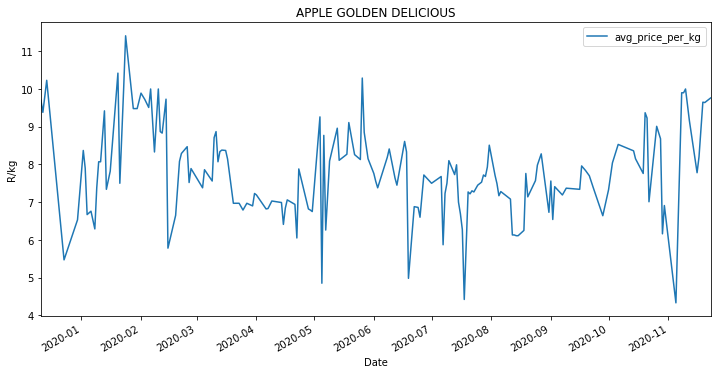

In [24]:
ax = price.plot(figsize=(12,6), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg');

In [25]:
# Create a copy so as to add some columns to the copied dataframe and not the original
copy_price = price.copy()

In [26]:
# Simple Moving Average for different periods
copy_price['5-day-SMA'] = copy_price['avg_price_per_kg'].rolling(window=5).mean() # Idealy a week
copy_price['5-day-Std'] = copy_price['avg_price_per_kg'].rolling(window=5).std() # 

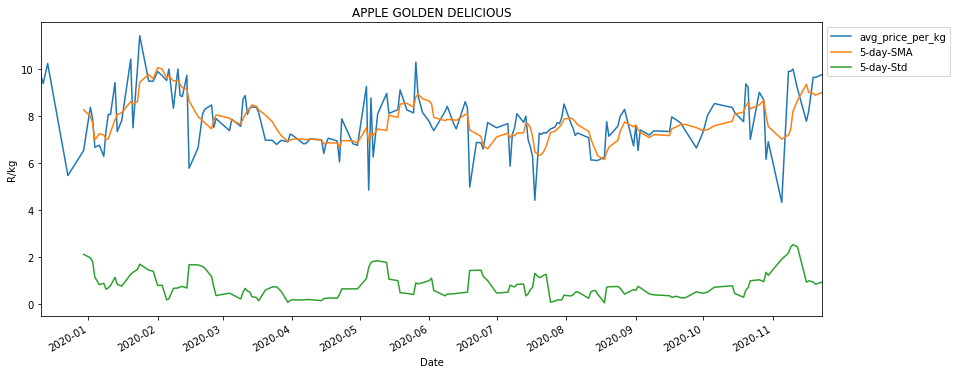

In [27]:
ax = copy_price[['avg_price_per_kg', '5-day-SMA', '5-day-Std']].plot(figsize=(14,6), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg')
ax.legend(bbox_to_anchor=(1,1));

## <a id="time-series-analysis">3. Time Series Analysis</a>

In [28]:
# View of the date index
price.index

DatetimeIndex(['2019-12-11', '2019-12-12', '2019-12-14', '2019-12-23',
               '2019-12-30', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-06', '2020-01-08',
               ...
               '2020-11-05', '2020-11-08', '2020-11-09', '2020-11-10',
               '2020-11-12', '2020-11-16', '2020-11-17', '2020-11-19',
               '2020-11-20', '2020-11-23'],
              dtype='datetime64[ns]', name='Date', length=168, freq=None)

The freq of the index is currently set to None, this will need to be changed to daily, since the frequency of the data is daily. Furthermore, since there is no data available for weekends, the freq has to be set to Business day (Mon-Fri), with a backfill method to account for those days when it is a holiday and no data updated. 

In [29]:
price = price.asfreq('B', method='backfill')
#price = price.asfreq('B')

In [30]:
price.head(10)

,avg_price_per_kg
Date,
2019-12-11,9.70
2019-12-12,9.38
2019-12-13,10.23
2019-12-16,5.47
2019-12-17,5.47
2019-12-18,5.47
2019-12-19,5.47
2019-12-20,5.47
2019-12-23,5.47


In [31]:
#price.interpolate(inplace=True)

### <a id="hodrick-prescott-filter">3.1 Hodrick-Prescott filter</a>

The Hodrick-Prescott filter is used to get the trend of the data. This approach separates the time-series into a trend component and a cyclical component.

In [32]:
price_cycle, price_trend = hpfilter(price)

In [33]:
price['trend'] = price_trend

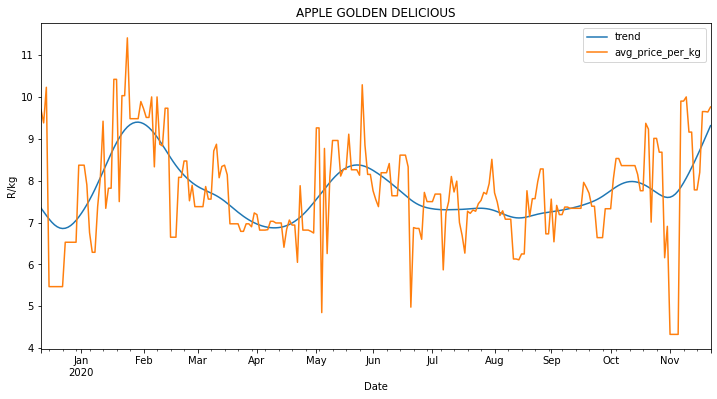

In [34]:
ax = price[['trend','avg_price_per_kg']].plot(figsize=(12,6), title="APPLE GOLDEN DELICIOUS")
ax.autoscale(axis='x', tight=True)
ax.set(ylabel='R/kg');

In [35]:
del price['trend']

### <a id="seasonal-decomposition">3.2 Seasonal Decomposition</a>

Time series decomposition involves the deconstruction of the time series data into the level, trend, seasonal and noise component. The model is assumed to be additive, i.e. value of our variable is given by the summation of it's deconstructed components.
<p style="text-align: center; font-weight: bold;">
$y(t) = level + trend + seasonality + noise$
</p>

In [36]:
rcParams['figure.figsize'] = 12,8

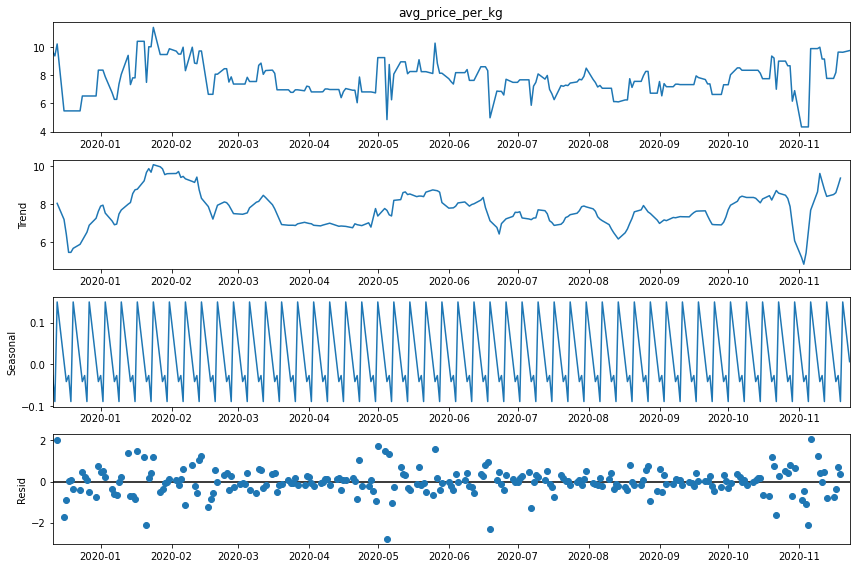

In [37]:
result = seasonal_decompose(price['avg_price_per_kg'], model='additive')  
result.plot();

### <a id="forecasting">3.3 Forecasting</a>

**Holt - Winters method**

Holt - Winters method is a generalized exponential smooothing method that incorporates **trend** and **seasonal** variation in the model. The model makes use of exponential weighting of the coefficients of past observations in order to give more weight to the most recent observations. 

In [38]:
train_data = price.iloc[:-30]
test_data = price.iloc[-30:]

In [39]:
model = ExponentialSmoothing(train_data['avg_price_per_kg'], trend='add',seasonal='add',seasonal_periods=7) 
# seasonal_periods=7 for daily data
fitted_model = model.fit()

In [40]:
test_predictions = fitted_model.forecast(30).rename('Forecast')

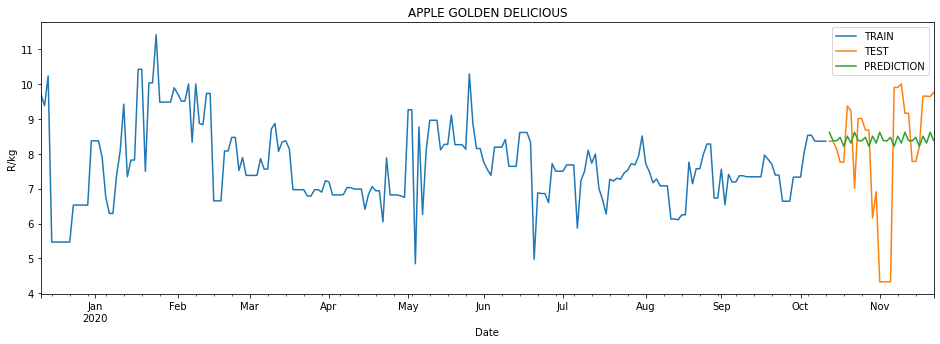

In [41]:
train_data['avg_price_per_kg'].plot(legend=True, label='TRAIN', figsize=(16,5))
test_data['avg_price_per_kg'].plot(legend=True, label='TEST')
ax = test_predictions.plot(legend=True, label='PREDICTION', title="APPLE GOLDEN DELICIOUS")
ax.set(ylabel="R/kg");

In [42]:
hw_pred = np.sqrt(mean_squared_error(test_data, test_predictions))

In [43]:
hw_pred

1.800039777526071

**Autoregressive (AR) model**

The Holt-Winters method forecasts the variable of interest using a linear combination of predictors. These predictors are the set of level, trend and seasonal predictors. 

The autoregression model uses a linear combination of past values of the variable. This is a regression equation whereby the variable of interest is regressed against a set of it's lagged values of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

In [44]:
def ar_model(data, lags=1):
    """
    Returns an AutoRegressive model specified by the number of lags
    
    Parameters
    -----------
    data: pd.Series
        A pandas series with a datetime index, and has frequency of the data specied 
    lags: int
        The number of lags that the AutoRegressive model will use
        
    Returns
    -------
    An AR model specified by the number of lags
    """
    
    model = AR(data)
    ar = model.fit(maxlag=lags)
    
    return ar    

In [45]:
# AR(1) model
ar1 = ar_model(train_data['avg_price_per_kg'])

In [46]:
# This is the general format for obtaining predictions
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = ar1.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [47]:
# Storage for scoring each of the models
scores = pd.DataFrame(columns=["RMSE"])
scores.index.name = "model"

In [48]:
scores.loc['AR(1)'] = np.sqrt(mean_squared_error(test_data, predictions1))

In [49]:
# AR(2) model
ar2 = ar_model(train_data['avg_price_per_kg'], lags=2)

In [50]:
predictions2 = ar2.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')
scores.loc['AR(2)'] = np.sqrt(mean_squared_error(test_data, predictions2))

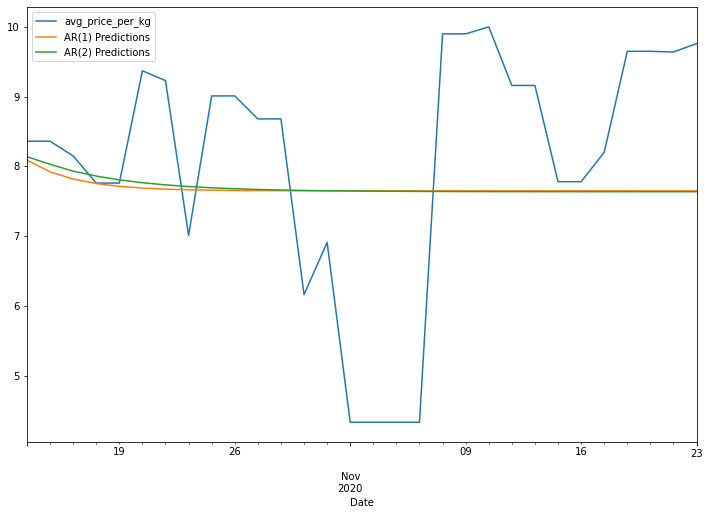

In [51]:
test_data['avg_price_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True);

In [52]:
scores.sort_values(by="RMSE")

,RMSE
model,
AR(2),1.781644
AR(1),1.785809


Based on the results, it can be seen that as the lags added increase, the RMSE is decreasing. Moreover, one needs to determine at what lag will the RMSE reach a minimum. 

In [53]:
ar_rmse = []
for i in range(1, 30): # 30 is an arbitrary number
    ar = ar_model(train_data['avg_price_per_kg'], lags=i)
    price_pred = ar.predict(start=start, end=end, dynamic=False)
    ar_rmse.append(np.sqrt(mean_squared_error(test_data, price_pred)))

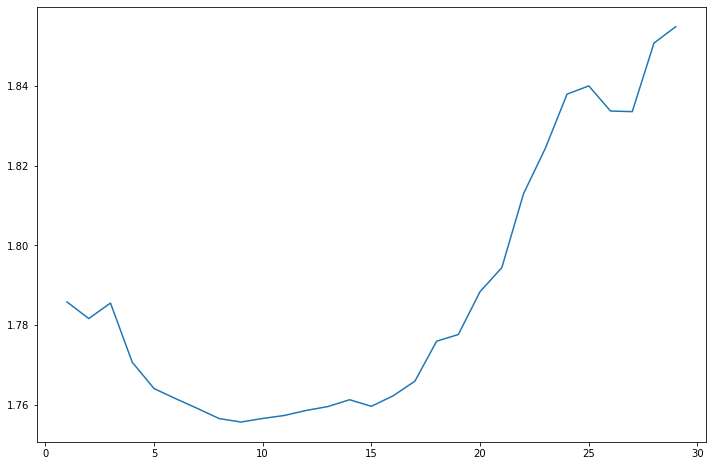

In [54]:
plt.plot(range(1, 30), ar_rmse);

In [55]:
# AR(5) model
ar5 = ar_model(train_data['avg_price_per_kg'], lags=5)
predictions5 = ar5.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')

In [56]:
scores.loc['AR(5)'] = np.sqrt(mean_squared_error(test_data, predictions5))

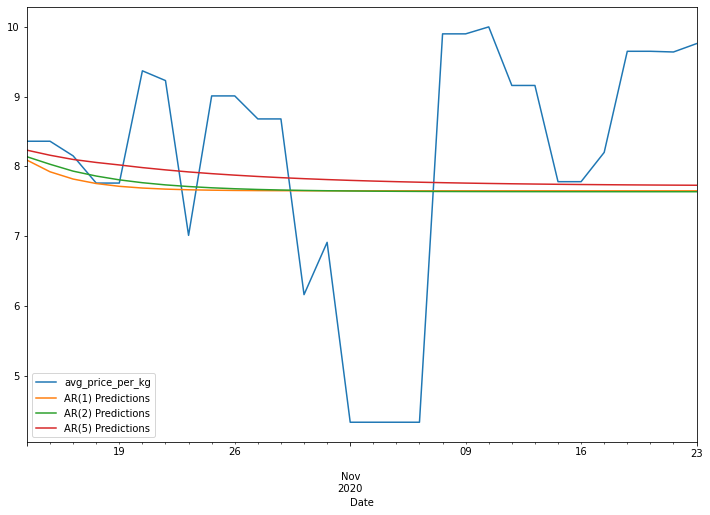

In [57]:
test_data['avg_price_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions5.plot(legend=True);

In [58]:
# Identify the best AR() model to use for forecasting
model = AR(train_data['avg_price_per_kg'])
arfit = model.fit(maxiter=1000)

In [59]:
arfit.params

const                   1.621370
L1.avg_price_per_kg     0.448982
L2.avg_price_per_kg     0.150674
L3.avg_price_per_kg     0.012721
L4.avg_price_per_kg     0.029177
L5.avg_price_per_kg     0.094782
L6.avg_price_per_kg     0.049722
L7.avg_price_per_kg     0.040624
L8.avg_price_per_kg    -0.092690
L9.avg_price_per_kg     0.126489
L10.avg_price_per_kg   -0.119542
L11.avg_price_per_kg    0.058503
L12.avg_price_per_kg    0.002097
L13.avg_price_per_kg    0.006068
L14.avg_price_per_kg    0.045352
L15.avg_price_per_kg   -0.061618
dtype: float64

In [60]:
# AR(15) model
ar15 = ar_model(train_data['avg_price_per_kg'], lags=15)
predictions15 = ar15.predict(start=start, end=end, dynamic=False).rename('AR(15) Predictions')

In [61]:
scores.loc['AR(15)'] = np.sqrt(mean_squared_error(test_data, predictions15))

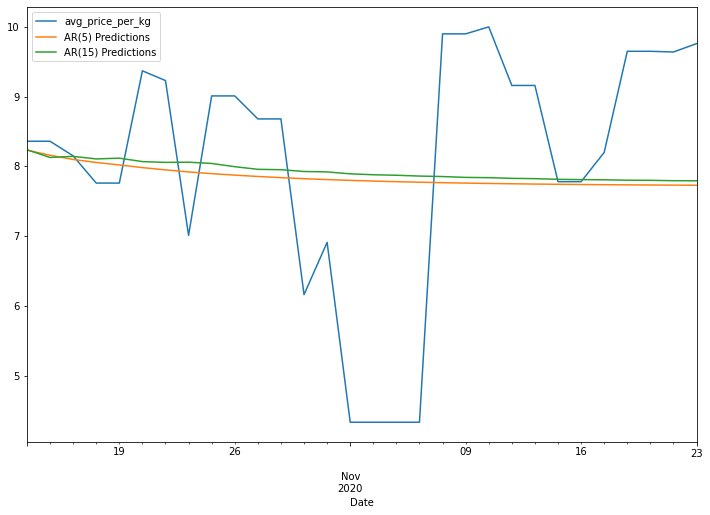

In [62]:
test_data['avg_price_per_kg'].plot(legend=True)
predictions5.plot(legend=True)
predictions15.plot(legend=True);

In [63]:
# AR(16) model
ar16 = ar_model(train_data['avg_price_per_kg'], lags=16)
predictions16 = ar16.predict(start=start, end=end, dynamic=False).rename('AR(16) Predictions')

In [64]:
scores.loc['AR(16)'] = np.sqrt(mean_squared_error(test_data, predictions16))

In [65]:
scores.sort_values(by="RMSE")

,RMSE
model,
AR(15),1.759653
AR(16),1.762282
AR(5),1.764116
AR(2),1.781644
AR(1),1.785809


**Autoregressive Integrated Moing Average (ARIMA) model**

ARIMA model is a combination of two models, the AR model utilizing past values of the time series data, and the Moving Average (MA) model, which uses past values of the forecast errors. 

### $$ y_{t} = c + \sum^p_{i=1} \phi_{i} y_{t-i} + \sum^q_{j=1} \theta_{j} \varepsilon_{t-j} + \varepsilon_{t} $$

As seen earlier, this models can be also be used separately, or in this section, combined. The fitting process returns estimated coefficients, $\phi_{i}$ and $\theta_{i}$, but prior to this process, the order ($p,q$) of the model needs to be determined.

In [66]:
model = auto_arima(train_data['avg_price_per_kg'],error_action='ignore', suppress_warnings=True, start_p=0, start_q=0,
                          max_p=6, max_q=3)

In [67]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  219
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -272.344
Date:                Mon, 30 Nov 2020   AIC                            552.689
Time:                        18:30:46   BIC                            566.245
Sample:                             0   HQIC                           558.164
                                - 219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3596      0.441      3.083      0.002       0.495       2.224
ar.L1          0.8237      0.055     15.023      0.000       0.716       0.931
ma.L1         -0.3369      0.072     -4.660      0.000      -0.479      -0.195
sigma2         0.7023      0.044     15.970      0.000       0.616       0.788
===================================================================================
Ljung-Box (Q):                       33.67   Jarque-Bera (JB):               229.97
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
model = ARIMA(train_data['avg_price_per_kg'],order=(1,0,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       avg_price_per_kg   No. Observations:                  219
Model:                     ARMA(1, 1)   Log Likelihood                -272.344
Method:                       css-mle   S.D. of innovations              0.838
Date:                Mon, 30 Nov 2020   AIC                            552.689
Time:                        18:30:47   BIC                            566.245
Sample:                    12-11-2019   HQIC                           558.164
                         - 10-12-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7.7141      0.210     36.787      0.000       7.303       8.125
ar.L1.avg_price_per_kg     0.8236      0.059     13.879      0.000       0.707       0.940
ma.L1.avg_price_per_kg    -0.3367      0.100     -3.363      0.001      -0.533      -0.140
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2142           +0.0000j            1.2142            0.0000
MA.1            2.9701           +0.0000j            2.9701            0.0000
-----------------------------------------------------------------------------
"""

In [69]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results.predict(start=start, end=end, typ='levels').rename("ARIMA(1,0,1) predictions")

In [70]:
#predictions = pd.Series(predictions, index=test_data.index)

In [71]:
rcParams['figure.figsize'] = 12,8

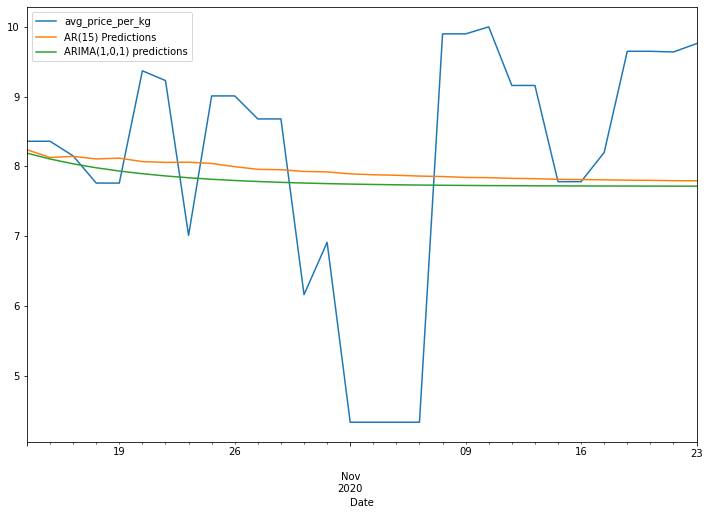

In [72]:
test_data['avg_price_per_kg'].plot(legend=True)
predictions15.plot(legend=True)
predictions.plot(legend=True);

In [73]:
scores.loc['ARIMA(1,0,1)'] = np.sqrt(mean_squared_error(test_data, predictions))

In [74]:
scores.sort_values(by="RMSE")

,RMSE
model,
AR(15),1.759653
AR(16),1.762282
AR(5),1.764116
"ARIMA(1,0,1)",1.765749
AR(2),1.781644
AR(1),1.785809


### Still needs to be looked at
- Granger Causality Test
- Vector AutoRegression (VAR) methods

## <a id="regression">4. Regression</a>

### <a id='reg-data-analysis'>4.1 Data Analysis</a>

In [75]:
# Reminder of how the dataFrame looks
df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,,A8075,,7.5,HABANERO YELLOW,2020-07-01,350.0,350.0,2100.0,6.0,45.0,18.0,46.67
1,,A8075,,7.5,HABANERO YELLOW,2020-07-08,350.0,350.0,4200.0,12.0,90.0,36.0,46.67
2,,A8075,,7.5,HABANERO YELLOW,2020-07-09,350.0,350.0,4200.0,12.0,90.0,36.0,46.67
3,,A8075,,7.5,HABANERO YELLOW,2020-07-14,350.0,350.0,3150.0,9.0,67.5,6.0,46.67
4,,A8075,,7.5,HABANERO YELLOW,2020-07-20,300.0,320.0,1860.0,6.0,45.0,0.0,41.33


In [76]:
df['low_price_per_kg'] = round(df['Low_Price'] / df['Weight_Kg'], 2)
df['high_price_per_kg'] = round(df['High_Price'] / df['Weight_Kg'], 2)

For time series analysis, the following format was followed when filtering the data:
```python
    filtered_df = df[
    (df['Commodities'] == 'APPLE GOLDEN DELICIOUS') & 
    (df['Weight_Kg'] == 12.0) &
    (df['Size_Grade'] == '1S') &
    (df['Container'] == 'EC120') &
    (df['Province'] == 'CAPE')
    ]
```
For regression, 'Province' will be excluded since where the product is from might affect the pricing.

In [77]:
filtered_df = df[
    (df['Commodities'] == 'APPLE GOLDEN DELICIOUS') & 
    (df['Weight_Kg'] == 12.0) &
    (df['Size_Grade'] == '1S') &
    (df['Container'] == 'EC120') 
]

In [78]:
apples = filtered_df[[
    'Province', 'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
    'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg', 'low_price_per_kg', 'high_price_per_kg'
]]

To check for multicollinearity, only numerical columns can be used.

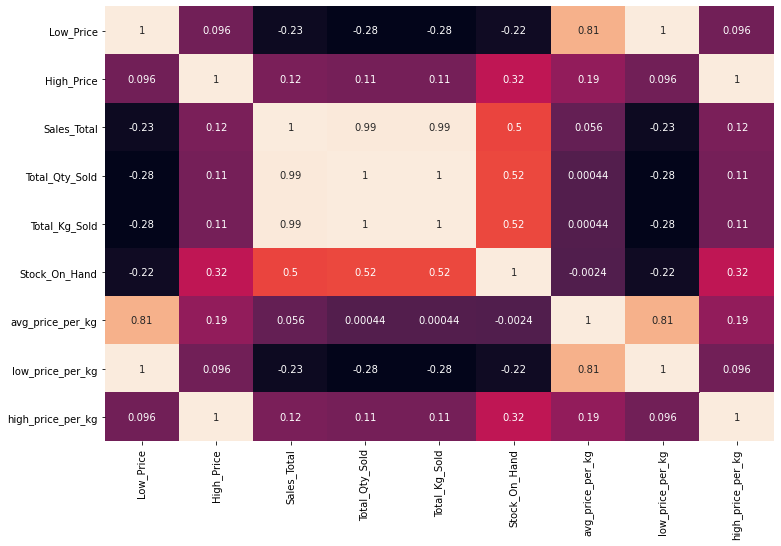

In [79]:
# Check for multicollinearity
sns.heatmap(apples.corr(), annot=True, cbar=False);

There is a high correlation amongst these three features **Sales_Total, Total_Qty_Sold** and **Total_Kg_Sold**. For the sake of determining inventory levels, only **Total_Qty_Sold** will remain. Furthermore there is also perfect correlation between **low_price_per_kg** and **Low_Price**, as well as between **high_price_per_kg** and **High_Price**. Since the target variable is in per kilogram terms, per kilograms values will remain. Although, there seems to be a high correlation between **avg_price_per_kg** and **low_price_per_kg**, for regression analysis the lagged values of the features are going to be used to predict the target variable, hence once the lag has been determined, correlations with the target variables will be assessed. 

In [80]:
apples.columns

Index(['Province', 'Date', 'Low_Price', 'High_Price', 'Sales_Total',
       'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg',
       'low_price_per_kg', 'high_price_per_kg'],
      dtype='object')

In [81]:
# High correlation columns shall be removed 
rem_col = ['Sales_Total', 'Total_Kg_Sold', 'Low_Price', 'High_Price']
# The remaining columns after removing correlated columns
cols = [col for col in apples.columns if col not in rem_col]

In [82]:
apples_df = apples[cols]

In [83]:
apples_df.head()

,Province,Date,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg
4675,CAPE,2019-12-11,66.0,2234.0,9.70,4.17,11.67
4676,CAPE,2019-12-12,2302.0,4140.0,9.38,8.33,12.00
4677,CAPE,2019-12-14,126.0,5730.0,10.23,8.33,11.67
4678,CAPE,2019-12-23,3038.0,12034.0,5.47,3.33,16.67
4679,CAPE,2019-12-30,1784.0,2544.0,6.53,4.17,11.67


### <a id='feature-engineering'>4.2 Feature Engineering and Visualizations</a>

In [84]:
apples_df['Province'].value_counts()

CAPE                    168
EASTERN CAPE             86
W.CAPE-BERGRIVER ETC     72
WEST COAST               19
NATAL                    16
TRANSVAAL                14
ORANGE FREE STATE         2
Name: Province, dtype: int64

Based on the frequency of purchases from each province, apples from ORANGE FREE STATE are the least regularly bought, one option is to remove these rows, another option is to combine it with TRANSVAAL and have them renamed as "INLAND". The latter option is the prefered since it means no data is lost. 

In [85]:
apples_df['Province'] = apples_df['Province'].apply(lambda x: x if x not in ["TRANSVAAL", "ORANGE FREE STATE"] else "INLAND")

In [86]:
apples_df['Province'] .value_counts()

CAPE                    168
EASTERN CAPE             86
W.CAPE-BERGRIVER ETC     72
WEST COAST               19
INLAND                   16
NATAL                    16
Name: Province, dtype: int64

In [87]:
def plot_swarmplot(data_frame, x, y):
    """
    Returns swarmplot based on variables of interest
    
    Parameters
    -----------
    data_frame: DataFrame
        A DataFrame containing x and y variables
    x, y: str
        Features of interest in the DataFrame, x and
        y plotted on the x-axis and y-axis respectively
    
    Returns
    --------
        A seaborn graph object
    """

    plt.figure(figsize=(16,5))
    sns.swarmplot(x=x, y=y, data=data_frame)
    plt.title("Price variations of Apples Golden Delicious");

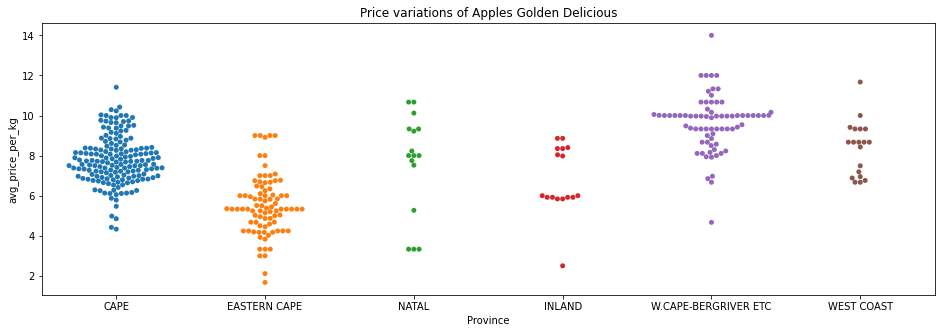

In [88]:
plot_swarmplot(apples_df, 'Province', 'avg_price_per_kg')

In [89]:
apples_df['weekday'] = apples_df['Date'].apply(lambda x: x.day_name())

In [90]:
apples_df['month'] = apples_df['Date'].apply(lambda x: x.month_name())

In [91]:
def season(month):
    """
    Returns the season of which the month falls in
    
    Parameters
    -----------
    month: str
        The month of the year as a full month name
    
    Returns
    --------
    str:
        The season of the year
        
    Examples
    ---------
    >>> season('October')
    'spring'
    """
    
    # Seasons
    summer = ['December', 'January', 'February']
    autumn = ['March', 'April', 'May']
    winter = ['June', 'July', 'August']
    spring = ['September', 'October', 'November']
    
    if month in summer:
        return 'summer'
    elif month in autumn:
        return 'autumn'
    elif month in winter:
        return 'winter'
    else:
        return 'spring'

In [92]:
apples_df['season'] = apples_df['month'].apply(season)

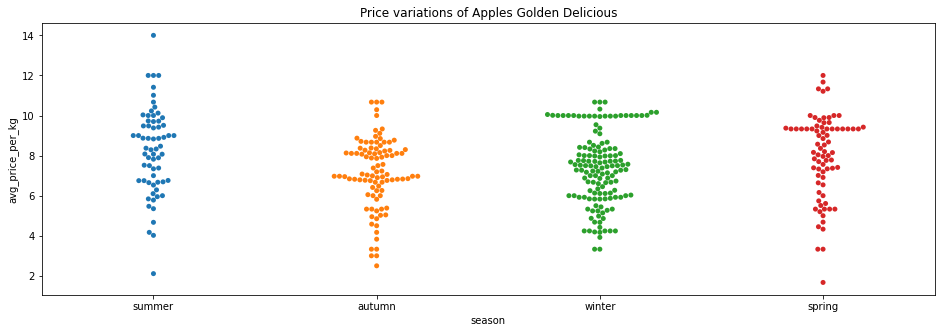

In [93]:
plot_swarmplot(apples_df, 'season', 'avg_price_per_kg')

Based on this plot, it can be concluded that since apples are not seasonal fruits, there appears to be no difference in average price per kilogram between the seasons. 

In [94]:
apples_df.sort_values('Date', inplace=True)

In [95]:
apples_df.head()

,Province,Date,Total_Qty_Sold,Stock_On_Hand,avg_price_per_kg,low_price_per_kg,high_price_per_kg,weekday,month,season
4675,CAPE,2019-12-11,66.0,2234.0,9.70,4.17,11.67,Wednesday,December,summer
4676,CAPE,2019-12-12,2302.0,4140.0,9.38,8.33,12.00,Thursday,December,summer
90425,W.CAPE-BERGRIVER ETC,2019-12-14,8.0,324.0,14.00,14.00,14.00,Saturday,December,summer
18690,EASTERN CAPE,2019-12-14,84.0,1152.0,6.00,6.00,6.00,Saturday,December,summer
4677,CAPE,2019-12-14,126.0,5730.0,10.23,8.33,11.67,Saturday,December,summer


In [96]:
# Check if end of the month(25th - 31st) will influence the prices
apples_df['is_month_end'] = apples_df['Date'].apply(lambda x: 1 if x.day in range(25,32) else 0)

In [97]:
# Remove white spaces in the Province name
apples_df['Province'] = apples_df['Province'].apply(lambda x: x.replace(" ", "_").replace("-", "_").replace(".", "_"))

In [98]:
apples_df['Province'].unique()

array(['CAPE', 'W_CAPE_BERGRIVER_ETC', 'EASTERN_CAPE', 'NATAL', 'INLAND',
       'WEST_COAST'], dtype=object)

In [99]:
X_features = list(filter(lambda x: x != 'avg_price_per_kg', apples_df.columns))

In [100]:
X = apples_df[X_features]
y = apples_df['avg_price_per_kg']

In [101]:
X.columns

Index(['Province', 'Date', 'Total_Qty_Sold', 'Stock_On_Hand',
       'low_price_per_kg', 'high_price_per_kg', 'weekday', 'month', 'season',
       'is_month_end'],
      dtype='object')

For the base model, certain features have to be dropped because they are only recorded after the product has been sold for that day, whereas prediction are based on what the average price per kilogram is going to be before any transaction has taken place. These columns that are going to be dropped include **low_price_per_kg**, **high_price_per_kg**, **Total_Qty_Sold** and **Stock_On_Hand**. Although these columns are dropped, their lagged values might serve as an input, that can be looked at later on. Furthermore, the **Date** has been used to generate features, hence it will also be dropped.

In [102]:
# List of columns to serve as input for the regression model
lst = [col for col in X.columns if col not in [
    'low_price_per_kg', 'high_price_per_kg', 'Stock_On_Hand', 'Date', 'Total_Qty_Sold'
]]

In [103]:
X = X[lst]

In [104]:
X.head()

,Province,weekday,month,season,is_month_end
4675,CAPE,Wednesday,December,summer,0
4676,CAPE,Thursday,December,summer,0
90425,W_CAPE_BERGRIVER_ETC,Saturday,December,summer,0
18690,EASTERN_CAPE,Saturday,December,summer,0
4677,CAPE,Saturday,December,summer,0


In [105]:
X = pd.get_dummies(X, drop_first=True)

In [106]:
X.head()

,is_month_end,Province_EASTERN_CAPE,Province_INLAND,Province_NATAL,Province_WEST_COAST,Province_W_CAPE_BERGRIVER_ETC,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,...,month_July,month_June,month_March,month_May,month_November,month_October,month_September,season_spring,season_summer,season_winter
4675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4676,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
90425,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
18690,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4677,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


Since time has been removed as a sequential feature, splitting the data in accordance with time is not needed. Therefore for the train_test_split, shuffle can still remain at True.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Initially, comparison is going to be between a linear regression model, and a constant average price.

In [108]:
mean_predict = np.ones(shape=(len(y_test),)) * y_train.mean()

In [109]:
base_pred = np.sqrt(mean_squared_error(y_test, mean_predict))

In [110]:
base_pred

1.7674341635234203

In [111]:
scores.loc['base_pred'] = base_pred

In [112]:
lr = LinearRegression()

In [113]:
lr.fit(X_train, y_train)

LinearRegression()

In [114]:
predict = lr.predict(X_test)

In [115]:
reg_rmse = np.sqrt(mean_squared_error(y_test, predict))

In [116]:
reg_rmse

1.216217655829293

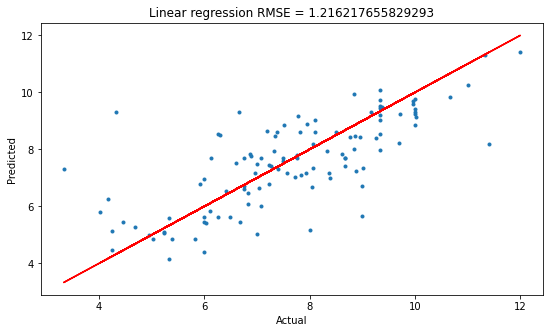

In [117]:
plt.figure(figsize=(9,5))
plt.plot(y_test, predict, '.')
plt.plot(y_test, y_test, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Linear regression RMSE = {reg_rmse}');

In [118]:
scores.loc['linear_regression'] = reg_rmse

In [119]:
scores.sort_values(by='RMSE')

,RMSE
model,
linear_regression,1.216218
AR(15),1.759653
AR(16),1.762282
AR(5),1.764116
"ARIMA(1,0,1)",1.765749
base_pred,1.767434
AR(2),1.781644
AR(1),1.785809


## <a id="deep-learning">5. Deep Learning</a>

For deep learning, a Long Short Term Memory (**LSTM**) was used to generate forecasts. LSTM is a special kind of recurrent neural network that is capable of learning long term dependencies in data. This is achieved because the recurring module of the model has a combination of four layers interacting with each other.
![image.png](attachment:image.png)

In [120]:
#Creating scaler to scale data between the range or (0,1)
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [121]:
test_data_scaled[:5]

array([[0.53506098],
       [0.53506098],
       [0.50304878],
       [0.44359756],
       [0.44359756]])

**Creating a time series generator from keras for our scaled train and test data**

In [122]:
generator = TimeseriesGenerator(train_data_scaled, train_data_scaled, length=15, batch_size=1)

**LSTM model**

In [123]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(15, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [124]:
#fitting the model
model.fit_generator(generator, epochs=30, verbose=0)

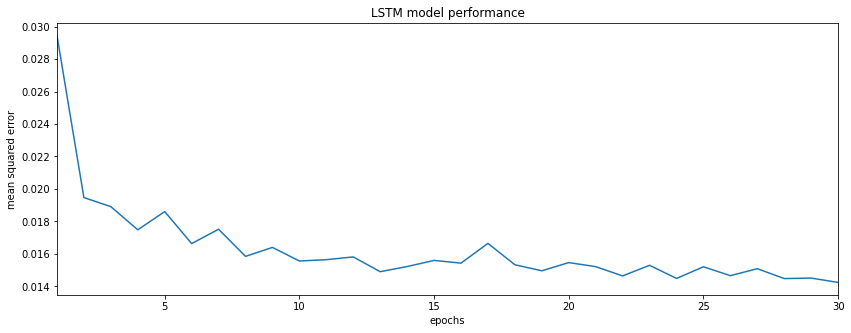

In [125]:
model_loss = model.history.history['loss']
plt.figure(figsize=(14, 5))
plt.plot(range(1, len(model_loss)+1), model_loss) 
plt.ylabel("mean squared error")
plt.xlabel("epochs")
plt.title("LSTM model performance")
plt.autoscale(axis='x', tight=True);

After a certain number of epochs the loss starts to converge to a certain value.

Using the model to predict the average price per KG

In [126]:
output=[]
reshaped_data=np.reshape(train_data_scaled[-15:],(1, 15, 1))
for i in range(len(test_data_scaled)):
    prediction=model.predict(reshaped_data)[0]
    output.append(prediction)
    reshaped_data=np.append(reshaped_data[:,1:,:],[[prediction]],axis=1) 

In [127]:
output = scaler.inverse_transform(output)
test_data['prediction'] = output
test_data.head()

,avg_price_per_kg,prediction
Date,,
2020-10-13,8.36,8.238706
2020-10-14,8.36,8.156586
2020-10-15,8.15,8.083523
2020-10-16,7.76,8.025769
2020-10-19,7.76,7.991869


In [128]:
lstm_rmse = np.sqrt(mean_squared_error(test_data['avg_price_per_kg'], output))

In [129]:
lstm_rmse

1.7646123751580927

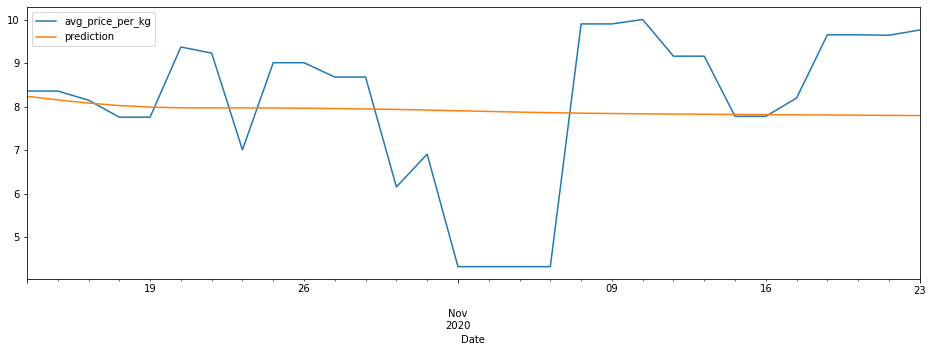

In [130]:
test_data['avg_price_per_kg'].plot(figsize=(16,5), legend=True)
test_data['prediction'].plot(legend = True)
ax.set(ylabel="R/kg");

In [131]:
scores.loc['LSTM'] = lstm_rmse

In [132]:
scores.sort_values(by='RMSE')

,RMSE
model,
linear_regression,1.216218
AR(15),1.759653
AR(16),1.762282
AR(5),1.764116
LSTM,1.764612
"ARIMA(1,0,1)",1.765749
base_pred,1.767434
AR(2),1.781644
AR(1),1.785809


# COnclusion

The data input has to be in equal intervals.